In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
use_platform = "cpu"

In [3]:
if use_platform == "cpu":
    import numpyro
    import multiprocessing as mp
    numpyro.set_host_device_count(mp.cpu_count() * 10)
    numpyro.set_platform("cpu")

In [4]:
import jax.numpy as jnp
import jax
from jax.example_libraries import optimizers

In [5]:
from tqdm.auto import tqdm
from rl_analysis.plotting import (
    setup_plotting_env,
    clean_ticks,
    savefig
)
from rl_analysis.util import whiten
from rl_analysis.photometry.encoding.loss import kernel_loss_spline, reconstruction
from rl_analysis.photometry.encoding.util import prepare_data, early_stopping
from sklearn import model_selection
from copy import deepcopy
from scipy.stats import pearsonr, zscore
from patsy import bs

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import optax

In [6]:
import toml

with open("../analysis_configuration.toml", "r") as f:
    analysis_config = toml.load(f)

In [7]:
data_dirs = analysis_config["data_dirs"]
proc_dirs = analysis_config["intermediate_results"]
lagged_cfg = analysis_config["dlight_lagged_correlations"]
figure_cfg = analysis_config["figures"]

# helper functions

In [8]:
from numba import jit, prange


@jit(nopython=True, parallel=True)
def shuffle_rows(x):
    idx = np.arange(x.shape[1])
    y = np.empty((x.shape[0], x.shape[1]))
    for i in prange(x.shape[0]):
        tmp = np.random.randint(-x.shape[1], +x.shape[1])
        rolled_idx = np.roll(idx, int(tmp))
        y[i] = x[i][rolled_idx]
    return y

In [9]:
from collections import defaultdict


def nested_dict():
    return defaultdict(nested_dict)

# Parameters

In [10]:
use_area = "dls" # note you need to re-run for DMS and DLS separately...

feature_variables = [
    "count_diff",
    "entropy_out_diff",
    "is_transition",
    "velocity_2d_mm",
    "acceleration_2d_mm",
    "velocity_angle",
    "velocity_height",
]


boxcar_len = 60
powers = 1
ncoeffs = 25  
group_key = "mouse_id"  # fit per X
params = {
    "kernel_length": 1200,
    "tsteps": 100,
    "stopping_threshold": 1e-4,
    "spline_params": {"df": ncoeffs, "degree": 3, "include_intercept": True},
}

opt_init, opt_update, get_params = optimizers.adam(step_size=1e-2)
save_path = os.path.join(
    proc_dirs["dlight"], f"encoding_model_ts_results_{use_area}_{group_key}.p"
)

splits = model_selection.KFold(n_splits=2)

# Load in pre-processed data

In [11]:
dlight_df = pd.read_parquet(
    os.path.join(proc_dirs["dlight"], "encoding_model_data_preprocessed.parquet")
)
dlight_df = dlight_df.loc[dlight_df["area"] == use_area].copy()

In [12]:
dlight_df["count_diff_trans"] = dlight_df["count_diff"]
dlight_df.loc[dlight_df["is_transition"] == 0, "count_diff_trans"] = np.nan

dlight_df["entropy_out_diff_trans"] = dlight_df["entropy_out_diff"]
dlight_df.loc[dlight_df["is_transition"] == 0, "entropy_out_diff_trans"] = np.nan

dlight_df["count_diff_trans"] = dlight_df.groupby("uuid")["count_diff_trans"].transform(
    lambda x: x.interpolate(method="quadratic")
)
dlight_df["entropy_out_diff_trans"] = dlight_df.groupby("uuid")[
    "entropy_out_diff_trans"
].transform(lambda x: x.interpolate(method="quadratic"))

In [13]:
use_df = dlight_df.dropna(subset=["signal_reref_dff_z"] + feature_variables)

In [14]:
smooth_func = lambda x: x.rolling(boxcar_len, 1, True).mean()
use_df["signal_reref_dff_z_smoothed"] = use_df.groupby("uuid")[
    "signal_reref_dff_z"
].transform(smooth_func)
use_df = use_df.dropna(subset=["signal_reref_dff_z_smoothed"])

/tmp/ipykernel_1540093/2115555280.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_df["signal_reref_dff_z_smoothed"] = use_df.groupby("uuid")[


In [15]:
powers_lst = []
for _ in feature_variables:
    if _ == "is_transition":
        continue
    for i in range(2, powers + 1):
        powers_lst.append((_, i))

if len(powers_lst) == 0:
    powers_lst = None

In [16]:
dlight_traces, feature_matrices, uuids, use_feature_names = prepare_data(
    use_df,
    feature_variables=feature_variables,
    dlight_key="signal_reref_dff_z_smoothed",
    powers=powers_lst,
    sz_cutoff=23 * 30 * 60, # sessions must be at least 23 minutes long
)

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
meta_df = use_df.drop_duplicates("uuid").set_index("uuid")[
    ["mouse_id", "session_number"]
].loc[uuids]

In [18]:
mouse_ids = meta_df.loc[uuids.tolist()]["mouse_id"]

In [19]:
feature_variables_series = pd.Series(use_feature_names)
syllable_idx = feature_variables_series.str.contains("count|entropy|transition").values
scalar_idx = feature_variables_series.str.contains("velocity").values
all_idx = np.ones(
    len(
        feature_variables_series,
    ),
    dtype="bool",
)

Spline basis model

In [20]:
chk_idx = {"syllable": syllable_idx, "scalar": scalar_idx, "all": all_idx}

In [21]:
spline_xvec = np.linspace(0, 1, params["kernel_length"])
spline_basis = bs(spline_xvec, **params["spline_params"])

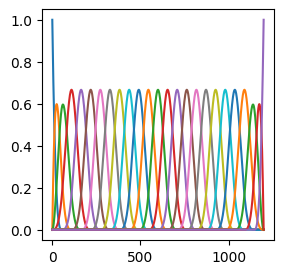

In [22]:
fig, ax = plt.subplots(1, figsize=(3, 3))
ax.plot(spline_basis)
plt.show()

In [23]:
w_results = [whiten(_) for _ in tqdm(feature_matrices)]

rot_mtx = np.mean([_[1] for _ in w_results], axis=0)
centered_data = [_ - _.mean(axis=0, keepdims=True) for _ in feature_matrices]
rotated_data = [_.dot(rot_mtx) for _ in centered_data]

  0%|          | 0/211 [00:00<?, ?it/s]

In [24]:
dlight_traces = zscore(dlight_traces, axis=1)
use_data = feature_matrices.copy()

In [25]:
use_data[..., syllable_idx] /= use_data[..., syllable_idx].std(axis=1, keepdims=True)
use_data[..., scalar_idx] -= use_data[..., scalar_idx].mean(axis=1, keepdims=True)
use_data[..., scalar_idx] /= use_data[..., scalar_idx].std(axis=1, keepdims=True)

In [26]:
kernel_grad_vectorized = jax.jit(
    jax.vmap(
        jax.grad(kernel_loss_spline, argnums=2), in_axes=(0, 0, None, None), out_axes=0
    )
)
kernel_loss_vectorized = jax.jit(
    jax.vmap(kernel_loss_spline, in_axes=(0, 0, None, None), out_axes=0)
)
reconstruction_vectorized = jax.jit(
    jax.vmap(reconstruction, in_axes=(0, None), out_axes=0)
)

In [27]:
@jax.jit
def update(i, opt_state, dlight_traces, feature_matrices):
    params = get_params(opt_state)
    return opt_update(
        i,
        kernel_grad_vectorized(
            dlight_traces, feature_matrices, params, spline_basis
        ).mean(axis=0),
        opt_state,
    )

In [28]:
init = np.random.randn(ncoeffs, use_data.shape[2]) * 0.001

In [29]:
dlight_traces = dlight_traces.astype("float32")
use_data = use_data.astype("float32")
spline_basis = spline_basis.astype("float32")
init = init.astype("float32")

In [30]:
group_vec = meta_df[group_key]
groups = np.unique(group_vec)

In [31]:
results = nested_dict()

In [32]:
for _group in tqdm(groups, desc="Total progress"):
    use_idx = np.flatnonzero(group_vec == _group)
    if len(use_idx) <= 1:
        continue
    og_kernels = deepcopy(init)

    for _fold, (train_idx, test_idx) in tqdm(
        enumerate(splits.split(use_idx)), total=splits.get_n_splits()
    ):
        train_idx = use_idx[train_idx]
        test_idx = use_idx[test_idx]
        for k, v in tqdm(chk_idx.items()):
            use_features = feature_variables_series.loc[v]
            losses = []
            pbar = tqdm(range(params["tsteps"]))

            opt_state = opt_init(init)

            for i in pbar:
                opt_state = update(
                    i, opt_state, dlight_traces[train_idx], use_data[train_idx][..., v]
                )
                losses.append(
                    kernel_loss_vectorized(
                        dlight_traces[train_idx],
                        use_data[train_idx][..., v],
                        get_params(opt_state),
                        spline_basis,
                    ).mean()
                )
                pbar.set_description(f"Loss: {losses[-1]:.03f}")
                if early_stopping(losses, threshold=params["stopping_threshold"]):
                    break

            fit = get_params(opt_state).copy()
            results["grand_ave_spline"]["kernels"][k]["fit"][_group][
                _fold
            ] = spline_basis.dot(fit).T
            results["grand_ave_spline"]["kernels"][k]["init"][_group][
                _fold
            ] = spline_basis.dot(og_kernels).T
            results["grand_ave_spline"]["recons"][k]["fit"][_group][_fold] = np.asarray(
                reconstruction_vectorized(
                    use_data[test_idx][..., v], spline_basis.dot(fit).T
                )
            )
            results["grand_ave_spline"]["recons"][k]["init"][_group][
                _fold
            ] = np.asarray(
                reconstruction_vectorized(
                    use_data[test_idx][..., v], spline_basis.dot(og_kernels).T
                )
            )
            results["grand_ave_spline"]["losses"][k][_group][_fold] = losses
            results["grand_ave_spline"]["feature_variables"][k] = use_features
        results["grand_ave_spline"]["dlight_data"]["dlight"][_group][
            _fold
        ] = dlight_traces[test_idx]
        results["grand_ave_spline"]["train_idx"][_group][_fold] = train_idx
        results["grand_ave_spline"]["test_idx"][_group][_fold] = test_idx
        results["grand_ave_spline"]["test_uuids"][_group][_fold] = uuids[test_idx]
        results["grand_ave_spline"]["train_uuids"][_group][_fold] = uuids[train_idx]

Total progress:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [33]:
results["grand_ave_spline"]["basis"] = spline_basis
results["grand_ave_spline"]["params"] = params
results["group_key"] = group_key

In [34]:
joblib.dump(results, save_path)

['/home/markowitzmeister_gmail_com/jeff_win_share/reinforcement_data/_final_test/_data/dlight_intermediate_results/encoding_model_ts_results_dls_mouse_id.p']

# Plotting

In [35]:
# LOAD IF WE ALREADY COMPUTED RESULTS
results = joblib.load(save_path)

In [36]:
setup_plotting_env()
sns.set_context("paper")

In [37]:
results["grand_ave_spline"]["dlight_data"].keys()

dict_keys(['dlight'])

In [38]:
use_features = results["grand_ave_spline"]["feature_variables"]["all"]
spline_basis = results["grand_ave_spline"]["basis"]
dlight_traces = results["grand_ave_spline"]["dlight_data"]["dlight"]
feature_variables_series = pd.Series(use_features)

In [39]:
train_uuids = np.concatenate(
    [
        np.concatenate(list(_.values()))
        for _ in results["grand_ave_spline"]["train_uuids"].values()
    ]
)
test_uuids = np.concatenate(
    [
        np.concatenate(list(_.values()))
        for _ in results["grand_ave_spline"]["test_uuids"].values()
    ]
)

In [40]:
col_wrap = 1
nrow = int(np.ceil(len(use_features) / col_wrap))

In [41]:
obs_rs = nested_dict()
groups = list(results["grand_ave_spline"]["dlight_data"]["dlight"].keys())

In [42]:
for k, v in tqdm(results["grand_ave_spline"]["recons"].items()):
    for _group in groups:
        obs_rs["grand_ave_spline"][k][_group] = []
        for _fold in range(splits.get_n_splits()):
            ref_vec = results["grand_ave_spline"]["dlight_data"]["dlight"][_group][
                _fold
            ]
            fit_vec = v["fit"][_group][_fold]
            obs_rs["grand_ave_spline"][k][_group].append(
                np.array([pearsonr(x, y)[0] for x, y in zip(ref_vec, fit_vec)])
            )

  0%|          | 0/3 [00:00<?, ?it/s]

In [43]:
plt_kernels = np.stack(
    [
        np.stack(
            list(results["grand_ave_spline"]["kernels"]["all"]["fit"][_group].values())
        )
        for _group in groups
    ]
)
ave_kernels = plt_kernels.mean(axis=1)

In [45]:
setup_plotting_env()

In [46]:
aliases = {
    "velocity": "vel",
    "_2d_mm": "",
    "count": "cnt",
    "transition": "trans",
    "entropy": "ent",
    "acceleration": "acc",
    "_diff": "",
    "angle": "ang",
    "height": "z",
    "is_": "",
}

In [47]:
yscale = 0.15
xscale = 2.5

In [48]:
plt_order = [
    "velocity_2d_mm",
    "acceleration_2d_mm",
    "velocity_height",
    "velocity_angle",
    "is_transition",
    "count_diff",
    "count_trans",
    "count_diff_trans",
    "count_ave_z",
    "count_ave_z_diff",
    "count_ave_z_trans",
    "entropy_out_diff_trans",
    "entropy_out_ave_z_diff",
    "entropy_out_diff",
]

In [49]:
plt_order = [_ for _ in plt_order if _ in use_features.tolist()]

In [50]:
suffix = f"powers-{powers}_smooth-{boxcar_len}-{use_area}"

In [51]:
show_ci = True
alpha = 0.99
nboots = 1000

rng = np.random.default_rng(0)

# bootstrap across the group, get percentiles, use for plotting if requested
bootstraps = np.stack(
    [
        ave_kernels[rng.choice(range(len(ave_kernels)), size=len(ave_kernels))].mean(
            axis=0
        )
        for _ in tqdm(range(nboots))
    ]
)

lo_ci = np.quantile(bootstraps, (1 - alpha) / 2, axis=0)
hi_ci = np.quantile(bootstraps, 1 - ((1 - alpha) / 2), axis=0)

  0%|          | 0/1000 [00:00<?, ?it/s]

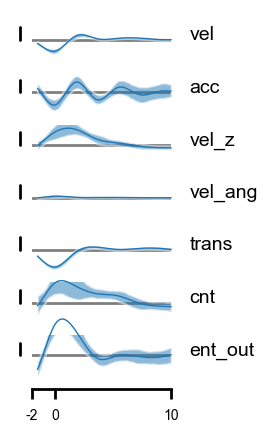

In [52]:
fig, ax = plt.subplots(
    nrow, col_wrap, figsize=(0.9 * col_wrap, 0.33 * nrow), sharey=True, sharex=True
)

try:
    iter(ax)
except:
    ax = np.array([ax])

for i, (_variable, _ax) in enumerate(zip(plt_order, ax.flat)):
    x = np.arange(-len(spline_basis) // 2, len(spline_basis) // 2) / 30.0
    idx = feature_variables_series.loc[feature_variables_series == _variable].index
    use_vals = np.flatnonzero((x >= -1.5) & (x <= 10))

    if show_ci:
        _ax.fill_between(
            x[use_vals],
            lo_ci[idx, use_vals],
            hi_ci[idx, use_vals],
            alpha=0.5,
        )

    _ax.plot(
        x[use_vals],
        ave_kernels.mean(axis=0)[idx, use_vals],
        label="learned",
        alpha=1,
        lw=0.5,
        clip_on=False,
    )

    _title = _variable
    for k, v in aliases.items():
        _title = _title.replace(k, v)
    xlim = _ax.get_xlim()
    ylim = _ax.get_ylim()

    _ax.text(xlim[1] + 1, 0, _title)
    yoffset = 0.05
    xoffset = 1
sns.despine()

for _ax in ax:
    _ax.set_ylim(-0.075, 0.075)
    _ax.set_xlim(-2, 10)
    _ax.axhline(y=0, zorder=-100, color=plt.rcParams["axes.edgecolor"], alpha=0.5)
    # _ax.axvline(x=0, zorder=-100, color=plt.rcParams["axes.edgecolor"], alpha=1)
    clean_ticks(_ax, "y", precision=2)
    clean_ticks(_ax, "x", precision=0, zero_symmetry=False, dtype=int)

sns.despine(offset=5)
for _ax in ax[:-1]:
    _ax.tick_params("x", length=0)
    _ax.spines["bottom"].set_visible(False)

full_range = 0
for _ax in ax:
    _ax.spines["left"].set_visible(False)
    _ax.set_yticks([])
    ylims = _ax.get_ylim()
    # halfpoint = (ylims[1] - ylims[0]) / 3
    halfpoint = 0
    _ax.plot(
        [-3, -3],
        [halfpoint, halfpoint + 0.05],
        color=plt.rcParams["axes.edgecolor"],
        clip_on=False,
    )
    full_range += ylims[1] - ylims[0] + 0.25

fig.subplots_adjust(hspace=0.3)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"convolution_regression_kernels_powers_withaxis_sharey-{suffix}",
    ),
    bbox_inches="tight",
)

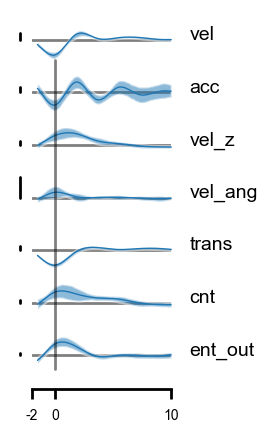

In [53]:
fig, ax = plt.subplots(
    nrow, col_wrap, figsize=(0.9 * col_wrap, 0.33 * nrow), sharey=False, sharex=True
)

try:
    iter(ax)
except:
    ax = np.array([ax])

for i, (_variable, _ax) in enumerate(zip(plt_order, ax.flat)):
    x = np.arange(-len(spline_basis) // 2, len(spline_basis) // 2) / 30.0
    idx = feature_variables_series.loc[feature_variables_series == _variable].index
    use_vals = np.flatnonzero((x >= -1.5) & (x <= 10))

    if show_ci:
        _ax.fill_between(
            x[use_vals],
            lo_ci[idx, use_vals],
            hi_ci[idx, use_vals],
            alpha=0.5,
        )

    _ax.plot(
        x[use_vals],
        ave_kernels.mean(axis=0)[idx, use_vals],
        label="learned",
        alpha=1,
        lw=0.5,
        clip_on=False,
    )

    # _ax.plot(x[use_vals], plt_kernels[[plt_fold],idx,use_vals].T, label="learned", alpha=1, lw=0.5, clip_on=False)

    _title = _variable
    for k, v in aliases.items():
        _title = _title.replace(k, v)
    xlim = _ax.get_xlim()
    ylim = _ax.get_ylim()

    _ax.text(xlim[1] + 1, 0, _title)
    yoffset = 0.05
    xoffset = 1
sns.despine()

for _ax in ax:
    # _ax.set_ylim(-.15, .15)
    _ax.set_xlim(-2, 10)
    _ax.axhline(y=0, zorder=-100, color=plt.rcParams["axes.edgecolor"], alpha=0.5)
    # _ax.axvline(x=0, zorder=-100, color=plt.rcParams["axes.edgecolor"], alpha=1)
    clean_ticks(_ax, "y", precision=2)
    clean_ticks(_ax, "x", precision=0, zero_symmetry=False, dtype=int)

sns.despine(offset=5)
for _ax in ax[:-1]:
    _ax.tick_params("x", length=0)
    _ax.spines["bottom"].set_visible(False)

full_range = 0
for _ax in ax:
    _ax.spines["left"].set_visible(False)
    _ax.set_yticks([])
    ylims = _ax.get_ylim()
    # halfpoint = (ylims[1] - ylims[0]) / 3
    halfpoint = 0
    _ax.plot(
        [-3, -3],
        [halfpoint, halfpoint + 0.02],
        color=plt.rcParams["axes.edgecolor"],
        clip_on=False,
    )
    full_range += ylims[1] - ylims[0] + 0.25

ax[-1].plot(
    [0, 0],
    [-0.15, full_range],
    "-",
    color=plt.rcParams["axes.edgecolor"],
    clip_on=False,
    alpha=0.5,
)
fig.subplots_adjust(hspace=0.3)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"convolution_regression_kernels_powers_withaxis_-{suffix}",
    ),
    bbox_inches="tight",
)

In [54]:
if use_area == "dls":
    fold_idx = 0
    # session_idx = 61

    # session_idx = 4
    # group_idx = groups[1]

    # session_idx = 3
    # group_idx = groups[1]

    session_idx = 6
    group_idx = groups[2]

    # session_idx = 5
    # group_idx = groups[2]

    # session_idx = 1
    # group_idx = groups[10]

else:
    fold_idx = 0
    # session_idx = 61
    session_idx = 4
    group_idx = groups[1]

In [55]:
group_idx

'dlight-chrimson-3'

In [56]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

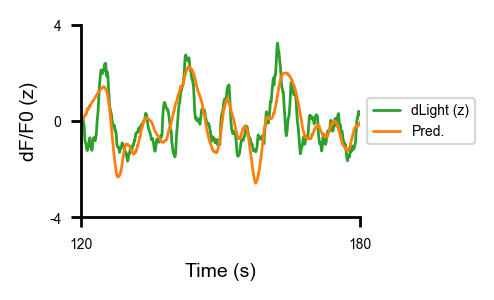

In [57]:
fig, ax = plt.subplots(1, figsize=(1.8, 1.25), sharex=True, sharey=True)
data = zscore(
    results["grand_ave_spline"]["dlight_data"]["dlight"][group_idx][fold_idx][
        session_idx
    ]
)
fit = zscore(
    results["grand_ave_spline"]["recons"]["all"]["fit"][group_idx][fold_idx][
        session_idx
    ]
)
xvec = np.arange(len(data)) / 30.0
ax.plot(xvec, data, label="dLight (z)", color=sns.color_palette()[2])
ax.plot(xvec, fit, label="Pred.", color=sns.color_palette()[1])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_ylim(-4, 4)
sns.despine()
ax.set_xlim(120.0, 180.0)
ax.set_xlabel("Time (s)")
ax.set_ylabel("dF/F0 (z)")
clean_ticks(ax, "y", precision=0, dtype=int)
clean_ticks(ax, "x", precision=-1, dtype=int, zero_symmetry=False)
savefig(
    fig,
    os.path.join(
        figure_cfg["store_dir"],
        f"convolution_regression_fit_example_{group_idx}-{fold_idx}-{session_idx}_{suffix}",
    ),
    bbox_inches="tight",
)

In [58]:
dcts = []
for _type, _group in obs_rs["grand_ave_spline"].items():
    for _group_key, _values in _group.items():
        _dct = {group_key: _group_key, "type": _type, "r": np.concatenate(_values)}
        dcts.append(_dct)

In [59]:
plt_df = pd.DataFrame(dcts).explode("r").reset_index(drop=True)

In [61]:
# save plt_df?
save_name = os.path.splitext(save_path)[0]
plt_df.to_parquet(f"{save_name}.parquet")

In [62]:
setup_plotting_env()

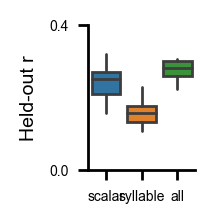

In [63]:
g = sns.catplot(
    data=plt_df.groupby(["mouse_id", "type"]).mean().reset_index(),
    x="type",
    y="r",
    kind="box",
    order=["scalar", "syllable", "all"],
    height=1.25,
    aspect=0.9,
    showcaps=False,
    showfliers=False
)
g.set_axis_labels("", "Held-out r")
g.set(ylim=(0, 0.4))
clean_ticks(g.axes.flat[0], "y", precision=2, zero_symmetry=False)
savefig(
    g.fig,
    os.path.join(
        figure_cfg["store_dir"], f"convolution_regression_heldoutr_refit_{suffix}"
    ),
    bbox_inches="tight",
)

In [64]:
plt_df["r"] = plt_df["r"].astype("float")

In [65]:
dump_data = plt_df.groupby("type").describe()
dump_data.columns = [_[1] for _ in dump_data.columns]

In [66]:
dump_data

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
all,211.0,0.282610,0.063573,0.133965,0.241295,0.280964,0.320145,0.506276
scalar,211.0,0.240297,0.066537,0.072989,0.195417,0.235122,0.285105,0.445849
syllable,211.0,0.165205,0.059957,0.007062,0.118396,0.159818,0.200709,0.416988


In [67]:
n_samples = list(dlight_traces.values())[0][0].shape[1]

In [68]:
with open(
    os.path.join(
        proc_dirs["dlight"], f"encoding_model_correlation_summary-{use_area}.toml"
    ),
    "w",
) as f:
    dct = dump_data.to_dict()
    dct["n_sessions_training"] = len(train_uuids)
    dct["n_sessions_testing"] = len(test_uuids)
    dct["n_samples"] = n_samples
    toml.dump(dct, f)

In [69]:
dct

{'count': {'all': 211.0, 'scalar': 211.0, 'syllable': 211.0},
 'mean': {'all': 0.2826101001944288,
  'scalar': 0.24029715135539395,
  'syllable': 0.1652053881741948},
 'std': {'all': 0.063573459175748,
  'scalar': 0.06653690218000487,
  'syllable': 0.05995657080385464},
 'min': {'all': 0.13396537863106578,
  'scalar': 0.07298860078354694,
  'syllable': 0.007062096943375661},
 '25%': {'all': 0.24129457563067414,
  'scalar': 0.19541660886261264,
  'syllable': 0.11839550913168381},
 '50%': {'all': 0.28096368533366384,
  'scalar': 0.23512183473617665,
  'syllable': 0.15981766756066906},
 '75%': {'all': 0.3201448662454824,
  'scalar': 0.28510542715867937,
  'syllable': 0.2007092219949015},
 'max': {'all': 0.506275783240241,
  'scalar': 0.4458492546117873,
  'syllable': 0.4169882410702937},
 'n_sessions_training': 211,
 'n_sessions_testing': 211,
 'n_samples': 41400}

In [70]:
nshuffles = 1000

In [71]:
groups = list(results["grand_ave_spline"]["dlight_data"]["dlight"].keys())

In [72]:
rng = np.random.default_rng(0)

In [73]:
dcts = []
for _shuffle in tqdm(range(nshuffles)):
    for _group in groups:
        fold_rs = []
        for _fold in range(splits.get_n_splits()):
            ref_vec = results["grand_ave_spline"]["dlight_data"]["dlight"][_group][
                _fold
            ]
            fit_vec = results["grand_ave_spline"]["recons"]["all"]["fit"][_group][_fold]
            fit_vec = fit_vec[rng.permutation(len(fit_vec))]
            fold_rs.append(
                np.array([pearsonr(x, y)[0] for x, y in zip(ref_vec, fit_vec)]).mean()
            )
        _dct = {group_key: _group, "shuffle": _shuffle, "r": np.mean(fold_rs)}
        dcts.append(_dct)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [74]:
shuffle_df = pd.DataFrame(dcts)

In [75]:
mus = plt_df.groupby("type")["r"].mean()
shuffle_rs = shuffle_df.groupby("shuffle")["r"].mean()

In [76]:
colors = sns.color_palette()

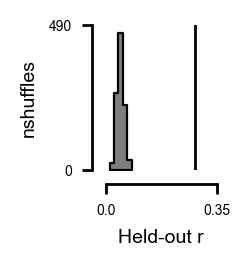

In [77]:
g = sns.displot(
    shuffle_rs,
    height=1.25,
    aspect=0.9,
    kind="hist",
    element="step",
    bins=5,
    color="k",
    alpha=0.5,
)
g.refline(x=mus.loc["all"], lw=1, ls="-", color="k")
g.set(xlim=(0, 0.35))
clean_ticks(g.axes.flat[0], "x", precision=2, zero_symmetry=False)
clean_ticks(g.axes.flat[0], "y", precision=-1, zero_symmetry=False, dtype=int)

g.set_axis_labels("Held-out r", "nshuffles")
sns.despine(offset=5)
savefig(
    g.fig,
    os.path.join(
        figure_cfg["store_dir"], f"convolution_regression_shuffle_dist_{suffix}"
    ),
    bbox_inches="tight",
)